In [1]:
import numpy as np
from hamiltonian_models import Ising

In [2]:
N = 4
T = 1

### Ising chain model creation

In [3]:
h = np.array([1 for j in range(N)])
J_chain = np.zeros((N, N))
for j in range(N - 1):
    J_chain[j, j + 1] = 1

J_cycle = np.copy(J_chain)
J_cycle[0, N - 1] = 1

Ising_chain = Ising(N, T, J_chain, h)

### Initialization step

In [4]:
from qiskit_ibm_provider import IBMProvider
from simuq.provider import BaseProvider
from simuq.solver import generate_as

In [5]:
#Init parameters of the IBMProvider
qs = Ising_chain
hub = "ibm-q-ncsu"
group = "nc-state"
project = "quantum-compiler"
api_file = "../ibm_API_key"
aais = 'heisenberg'
backend = 'ibm_nazca'
tol = 0.01
trotter_num = 6
verbose = 0
use_pulse = True
state_prep = None

In [6]:
#Init functionality of the IBMProvider
from qiskit import IBMQ
with open(api_file, "r") as f:
        api_key = f.readline().strip()

#provider = IBMQ.enable_account(api_key, hub='ibm-q-ncsu', group='nc-state', project='quantum-compiler')
provider = IBMProvider(api_key,instance=hub + '/' + group + '/' + project)

### Compilation step

In [7]:
backend = provider.get_backend(backend)
nsite = backend.configuration().n_qubits

if qs.num_sites > nsite:
    raise Exception("Device has less sites than the target quantum system.")

if aais == "heisenberg":
    import ibm
    from qiskit_pulse_ibm import transpile

    mach = ibm.generate_qmachine(backend)
    comp = transpile

In [8]:
layout, sol_gvars, boxes, edges = generate_as(
    qs,
    mach,
    trotter_num,
    solver="least_squares",
    solver_args={"tol": tol},
    override_layout=None,
    verbose=verbose,
)

print(layout)

[0, 1, 2, 3]


In [9]:
circ = []

for i in range(6):
    circ.append(comp(
        backend,
        layout,
        sol_gvars,
        boxes,
        edges,
        use_pulse=True,
        noise_factor=i
    ))

In [10]:
from qiskit import transpile as transpile_qiskit
transpiled_circ = []

for i in range(len(circ)):
    transpiled_circ.append(transpile_qiskit(circ[i],backend))

In [23]:
from qiskit import execute
job = execute([transpiled_circ[0]], shots=1024, backend=backend)
print(job.job_id())

cnnxcx324wx0008fbbmg


In [12]:
#from qiskit import execute
#for i in range(len(transpiled_circ)):
#    job = execute([transpiled_circ[i]] * 5, shots=1024, backend=backend)
#    print(job.job_id())

In [13]:
#Run the job on Sampler primitive of IBM Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_nazca")
options = Options()
options.resilience_level = 1
sampler = Sampler(backend=backend,options=options)

job = sampler.run(transpiled_circ[0], shots=1024)


In [14]:
result = job.result()
quasi_dists = result.quasi_dists
print(quasi_dists)

[{2: 0.001154540402345, 6: -0.002914097002899, 14: 0.00135700956085, 67110918: 0.000977450368443, 18253611021: 0.000977520799189, 4398046511110: 0.000838656364498, 4398046576647: 0.001150349738651, 8796093022209: 0.000995081838503, 8796093022214: 0.006242449228433, 8796160131086: 0.000969661823891, 8796227305478: 0.001030933895091, 13211319402501: 0.000973931448937, 35184372351010: 0.000976747316447, 43980481953799: 0.000987750523914, 149533581410310: 0.000977593062936, 334251534909444: 0.000976569319008, 598701261193222: 0.00097876076607, 2291384916639750: 0.000976563367104, 9055577833537539: 0.000976509704207, 18018796556058630: 0.001045045620033, 45071202120695814: 0.000976558932771, 72057611217797126: 0.001125685798868, 72068597744205830: 0.000977091754848, 72070788177461255: 0.001078571837196, 72070788177723398: 0.000975675877166, 72070788446945284: 0.000976573325023, 72070796767400010: 0.000976539716094, 72101574503047172: 0.000976529853507, 76596386627321869: 0.000976562453468, 

In [15]:
from qiskit.result import QuasiDistribution
quasi_dists = QuasiDistribution(result.quasi_dists[0],shots=1024)
quasi_dists.nearest_probability_distribution()

{37037607733541470214: 0.0005737946765966298,
 151115871567016722694151: 0.0005883053412179959,
 216177180160294919: 0.0007094074315453651,
 147718072175798779909: 0.0007292557348906625,
 151263517625578948657159: 0.0007442138155856652,
 151115871580210862227462: 0.0007564592284656523,
 151263301417612462850054: 0.000772571362159656,
 37779003920568379506694: 0.0008303761395453887,
 144159185720836103: 0.0008327171114590754,
 4398046511110: 0.0008338390989910736,
 10633823966279326983302518474327195654: 0.0008368078991486835,
 151263301408816369827855: 0.0008515978981845794,
 151263517616782855634950: 0.0008624665900265568,
 151263301413214416338958: 0.0008725579142311805,
 633825300261688666549347418118: 0.0008742367991263256,
 151263301444000741851141: 0.0008857384912218394,
 151272524780870404407302: 0.0008936219431833123,
 147718067794932137998: 0.0008958530515963261,
 149879839596535087110: 0.000896650327922795,
 38074079768136514539527: 0.000897417051393998,
 15111574547064238270

In [16]:

binary_key_lambda = lambda x: bin(x)[2:].zfill(127) #Convert number to binary and left pad with 127 zeros
binary_keys = map(binary_key_lambda, quasi_dists.keys())

modified_dict = dict(zip(binary_keys, quasi_dists.values()))

In [25]:
modified_dict = provider.retrieve_job('cnnxcx324wx0008fbbmg').result().get_counts()

In [26]:
def process_results(result,layout):

    def layout_rev(res):
        n = len(layout)
        # print(self.layout)
        b = res
        ret = ""
        for i in range(n):
            ret += b[-1 - layout[i]]
        return ret


    n_shots = sum(result.values())

    from collections import defaultdict

    def default_value():
        return 0

    ret = defaultdict(default_value)

    for key in result.keys():
        new_key = layout_rev(key)
        ret[new_key] += result[key] / n_shots

    return ret

processed_results = process_results(modified_dict,layout)

In [27]:
#Getting the ideal results
from hamiltonian_models import Ising
from simuq.qutip import QuTiPProvider
import numpy as np

def get_ideal_result(N,T):
    #Ising chain model creation
    h = np.array([1 for j in range(N)])
    J_chain = np.zeros((N, N))
    for j in range(N - 1):
        J_chain[j, j + 1] = 1

    J_cycle = np.copy(J_chain)
    J_cycle[0, N - 1] = 1
    Ising_chain = Ising(N, T, J_chain, h)

    #Classical simulation
    qtpp = QuTiPProvider()
    qtpp.compile(Ising_chain)
    qtpp.run()

    return qtpp.results()

ideal_result = get_ideal_result(4,1)

Compiled.
Solved.


In [28]:
from qiskit.quantum_info import hellinger_fidelity

hellinger_fidelity(processed_results,ideal_result)

0.33742702420435594

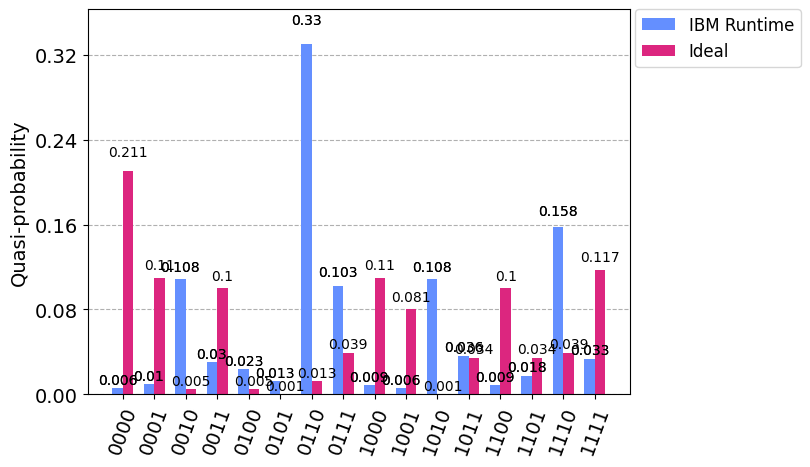

In [29]:
from qiskit.visualization import plot_histogram

plot_histogram([processed_results,ideal_result],legend=['IBM Runtime','Ideal'])